# <i class="fa-solid fa-handshake"></i> Bias-Variance Tradeoff

Before we dive into the concept of bias, let’s briefly recap some theoretical concepts you learned about in the lecture. When we talk about fitting machine learning models, we are referring to the process of estimating a function $f$ that best represents the relationship between an outcome and a set of labelled data (in supervised learning) or to uncover structural patterns in unlabelled data (in unsupervised learning). While the estimated function $\hat{f}$​ conveys important information about the data from which it was derived (the training data), our primary interest is in using this function to make accurate predictions for future cases in new, unseen data sets. 

The fundamental question in statistical learning is how well $\hat{f}$​ will perform on these future data sets, which brings us to the concept of the *bias-variance tradeoff*. Bias occurs when a model is too simple to capture the underlying complexities of the data, leading to systematic inaccuracies in its predictions. Variance measures how much the model's predictions fluctuate when trained on different subsets of the data.

```{admonition} Reminder: Types of Errors
:class: note

- The *irreducible error* is inherent in the data due to noise and factors beyond our control (unmeasured variables).

- The *reducible error* arises from shortcomings in the model and can be further broken down into:
  - *Bias*: Introduced when a model makes too simple assumptions about the data (underfitting)
  - *Variance*: The sensitivity of the model to small changes in the training data (overfitting)
```

This closely relates to the example introduced in [](0_refresher). Let's have a another look and simulate some data with an underlying relationship in line with a cubic polynomial function. We can see that a linear regression does not capture the nuance of the cubic relationship in the data, while a 10th order model already overfits quite a lot:

```{code-block} ipython3
import numpy as np

x = np.linspace(-3, 3, 30)
y = (x**3 + np.random.normal(0, 15, size=x.shape)) / 10
```

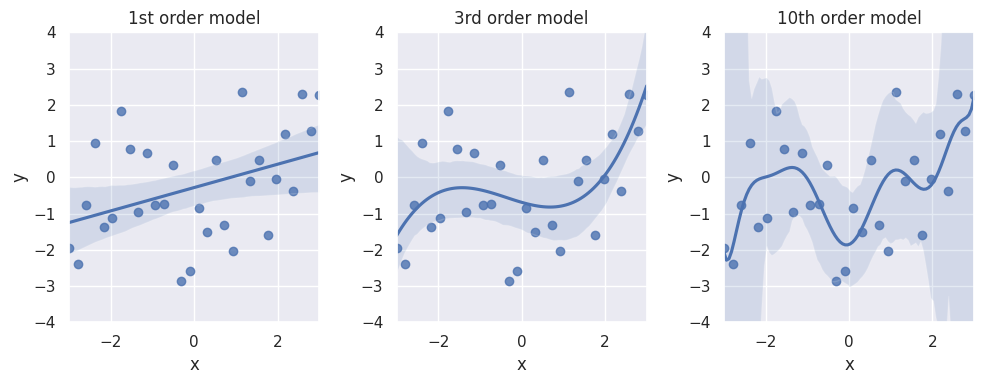

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()
np.random.seed(42)

x = np.linspace(-3, 3, 30)
y = (x**3 + np.random.normal(0, 15, size=x.shape)) / 10
df = pd.DataFrame({'x': x, 'y': y})

fig, ax = plt.subplots(1,3, figsize=(10,4))
sns.regplot(df, x="x", y="y", ax=ax[0], order=1)
sns.regplot(df, x="x", y="y", ax=ax[1], order=3)
sns.regplot(df, x="x", y="y", ax=ax[2], order=10)

titles = ["1st order model", "3rd order model", "10th order model"]
for a, title in zip(ax, titles):
    a.set(title=title)
    a.set_xlim(-3, 3)
    a.set_ylim(-4, 4)

plt.tight_layout()

If we look at the mean squared error (MSE), which we here use as a measure for the *bias*, we can see that it decreases with increasing model flexibility:


```{admonition} Reminder: MSE
:class: dropdown

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

- $y_i$ is the actual value for the $i$-th observation.
- $\hat{y}_i$ is the predicted value for the $i$-th observation.
- $n$ is the total number of observations

The term $({y_i}−{\hat{y}^i})^2$ represents the squared error for each observation. By averaging these squared errors, the MSE provides a single metric that quantifies how far off the predictions are from the true values.
```

In [2]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# Create data
np.random.seed(42)
x = np.linspace(-3, 3, 30).reshape(-1, 1)
y = (x**3 + np.random.normal(0, 15, size=x.shape)) / 10

# Run the models and calculate the MSE
mse_list = []
model_list = []
degrees = [1, 3, 10]

for degree in degrees:
  x_trans = PolynomialFeatures(degree=degree).fit_transform(x)
  model = sm.OLS(y, x_trans).fit()
  mse = np.mean(model.resid**2)

  model_list.append(model)
  mse_list.append(mse)

print(f"Degree  Train MSE")
print(f"1       {mse_list[0]:.3f}")
print(f"3       {mse_list[1]:.3f}")
print(f"10      {mse_list[2]:.3f}")

Degree  Train MSE
1       1.809
3       1.417
10      1.094


However, if we evaluate the same models on new, unseen data, we see that the MSE is now increasing with incrasing order of the polynomial regression model:

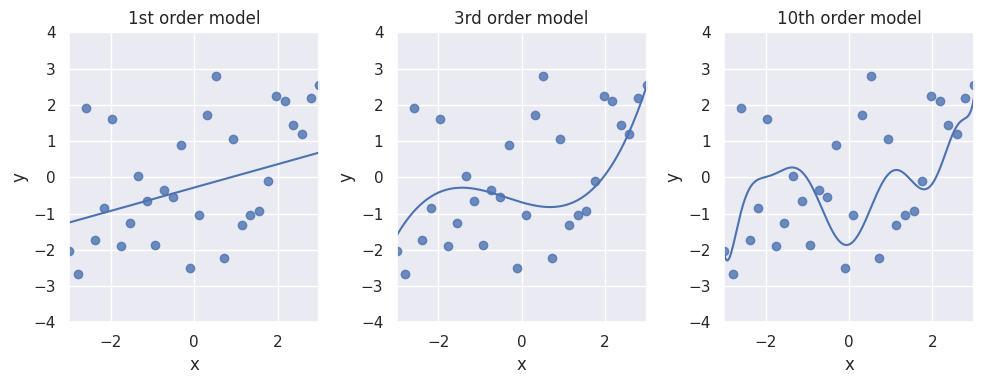

Degree  Test MSE
1       2.203
3       2.046
10      2.478


In [3]:
# Create data
np.random.seed(42)
x_train = np.linspace(-3, 3, 30)
y_train = (x_train**3 + np.random.normal(0, 15, size=x_train.shape)) / 10

np.random.seed(5)
x_test = np.linspace(-3, 3, 30)
y_test = (x_test**3 + np.random.normal(0, 15, size=x_test.shape)) / 10
df_test = pd.DataFrame({'x': x_test, 'y': y_test})

# Create plot
fig, ax = plt.subplots(1,3, figsize=(10,4))
orders = [1, 3, 10]
titles = ["1st order model", "3rd order model", "10th order model"]
predictions = []

for a, order, title in zip(ax, orders, titles):
  coeffs = np.polyfit(x_train, y_train, order)
  x_fit = np.linspace(-5, 5, 400)
  y_fit = np.polyval(coeffs, x_fit)
  y_pred = np.polyval(coeffs, x_test)
  predictions.append(y_pred)

  sns.regplot(data=df_test,  x="x", y="y", ax=a, fit_reg=False)
  a.plot(x_fit, y_fit, color='#4c72b0')

  a.set(title=title)
  a.set_xlim(-3, 3)
  a.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

# Calculate the test MSE
resids = [pred - y_test for pred in predictions]
mses = [np.mean(resid**2) for resid in resids]

print(f"Degree  Test MSE")
print(f"1       {mses[0]:.3f}")
print(f"3       {mses[1]:.3f}")
print(f"10      {mses[2]:.3f}")

Please compare the previous plots and outputs. What do you notice?

```{admonition} Show answer
:class: dropdown
Two things should become apparent:

1. In contrary to the training MSE, which decreases with the order of the model, the test MSE is lowest for the 3rd order model.
2. The test MSEs are generally higher than the training MSEs. This is to be expected as the intial models did all, to some degree, fit to the noise in the training data.
```

This is because the 10th order model has too much *variance* - it is too close to the training data. If we fit such a model to multiple draws of samples from the population with a true association consistent with the cubic order polynomial, the model's predictive performance will always look different:

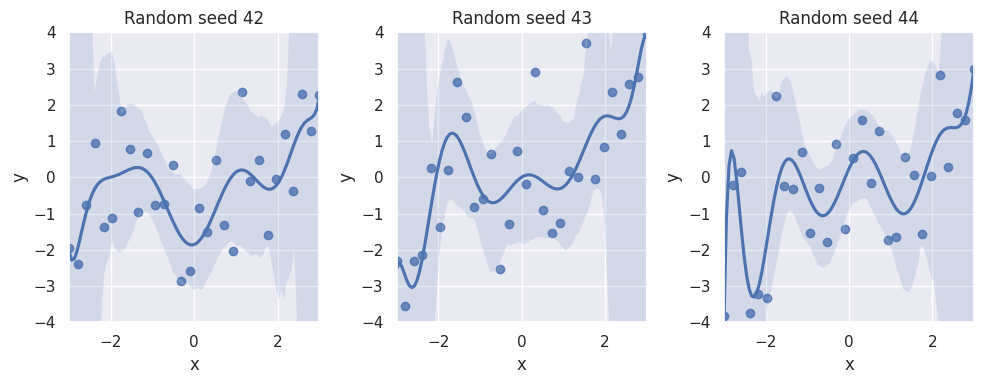

In [4]:
seeds = [42, 43, 44]
fig, ax = plt.subplots(1,3, figsize=(10,4))

for a, seed, title in zip(ax, seeds, titles):
  np.random.seed(seed)
  x = np.linspace(-3, 3, 30)
  y = (x**3 + np.random.normal(0, 15, size=x.shape)) / 10
  df = pd.DataFrame({'x': x, 'y': y})

  sns.regplot(data=df,  x="x", y="y", ax=a, order=10)
  a.set(title=f"Random seed {seed}")
  a.set_xlim(-3, 3)
  a.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

```{figure} figures/bias_variance.drawio.png
:alt: BiasVarianceTradeOff
:width: 300
:align: right

Bias-variance tradeoff
```

When we increase the flexibility of the model by adding more parameters, we are effectively trading between bias and variance. Initially, as the model becomes more flexible, its bias decreases quickly because it can capture more complex patterns in the data. However, this increased flexibility also makes the model more sensitive to the noise in the training data, which leads to a rise in variance.

Eventually, the reduction in bias is no longer sufficient to counterbalance the increase in variance. This is why a model with a very low training MSE may still suffer from a high test MSE: the low training error is primarily a result of fitting the noise (i.e., high variance), rather than capturing a true underlying pattern.

<br>

```{admonition} Summary
:class: tip

Our goal is to minimize the reducible error by finding an optimal balance between bias and variance. Only then do we have a model that not only performs well on the training data but also generalizes effectively to new, unseen data.
```

In [5]:
from jupyterquiz import display_quiz
display_quiz('quiz/bias_variance.json')

<IPython.core.display.Javascript object>